# Introduction

# Business Understanding

In a time where Netflix faces serious competition from a variety of streaming services that have come up, able to leverage their affiliation with networks to claim a number of successful TV shows to boost their subscribers and libraries, Netflix has one competitive edge: the ease of usability and technical superiority. If Netflix wants to remain a serious competitor in the streaming business, it cannot falter in this crucial aspect, and must continually adjust its platforms and respond to the faults which can drive away consumers and subscribers. Additionally, we want to understand which aspects of our platform resonate positively with consumers, so that we have a better idea of how to go about marketing our product in relevant ways, as well as gaining deeper knowledge about which aspects of our product can be developed further to deepen our consumers' appreciation.

We are tasked with addressing this very issue: locating trends among negative user reviews so that we can adjust our product and continue to provide a top-tier streaming service that stands above the rest in technical terms, as well as trends among positive reviews so we can better understand which aspects of our product are best emphasized in our future marketing campaigns. We will particularly pay close attention to reviews produced over the past year or so, to ensure that our interventions are timely and relevant to the issues faced by our clientele in the currrent moment or very recent past. Focusing on recent reviews also provides clarity of action, as there is little point in us locating trends among negative reviews from a few years back that had already been addressed in the time since, for example. 

Put another way, we seek to gain a better understanding of the following:
1. **Retention**, and why some users are unhappy with Netflix and may cancel their subscriptions.
2. **Marketing Insights**, and identify what it is that people currently appreciate about Netflix so it can inform our promotions.

What this requires of us is:
1. To build a **binary classification model** that can deploy Natural Language Processing (NLP), or more specifically, **Sentiment Analysis** on the user reviews, and use that insight to predict whether the review is positive or negative. This can be done through traditional supervised learning models, such as Logistic Regression, Random Forest Classifiers, SVM, etc.
2. Apply **clustering methods** to both groups of positive and negative reviews to identify trends and themes that will inform the actions we take.

In this way, we will be better equipped to provide solid business recommendations regarding subscriber retention as well as more effective marketing campaigns.

# Data Understanding

The [dataset we will be working with](https://www.kaggle.com/datasets/ashishkumarak/netflix-reviews-playstore-daily-updated?resource=download) was pulled from Kaggle and contains more than 129,000 reviews dating back to 2018, which is 7 years as of the time of  writing. This dataset is updated daily, and the data contained within it is up-to-date as of 2 March, 2025.

Of the 8 columns contained in this dataset, the following are of particular or potential interest to us, pending further investigation:
1. `content`, which contains the text of the user review. We will use this column for our NLP and Sentiment Analysis.
2. `# score`, which contains a discrete (categorical) numeric rating on a scale of 1-5. This will serve as our Target column whose Labels we will predict based on the the text of the user reviews.
3. `# thumbsUpCount`, which tells us how many 'thumbs up' each user review received from other reviews, potentially indicating the relative significance of different reviews since a higher count of thumbs up would indicate the review resonated with other users.
4. `at`, telling us the date the user review was created. We will be looking to filter our data so that we can focus on reviews produced over the past year 1-2 years, or since 2023.

### Features 
We will use the text contained within the `content` column to produce features for our classifier by vectorizing the text using **Term Frequency-Inverse Document Frequency (TF-IDF)**, which is a useful strategy for determing the relative significance of terms used in the user reviews by weighing the frequency of their appearances within a review against their relative rarity across all reviews in consideration. 

### Targets
The `# score` column will be used as our Target column by combining the low ratings (1 and 2) as a Negative class and combining the positive reviews (4 and 5) as a Positive class, and turning these classes into binaries: 0 for Negative, 1 for Positive.

We will be disregarding the ratings of 3 as we want a clear understanding of what makes a review strictly negative vs. strictly positive, and a middle of the road review of 3, as insightful as its content may be, would hinder our ability to understand the division of these sentiments.

### Class Distribution
Fortunately for us, the distribution of our Negative and Positive classes are relatively balanced, with a slight skew towards Negative.
- Negative: 61%
- Positive: 39%

### Success Metrics
In order to evaluate the performance of our models, we will be using the **F1 Score**, which is the harmonic mean between the rates of False Negatives and False Positives generated by our models. It will additionally be useful in this case since False Negatives are not necessarily more detrimental to our purposes than False Positives. Due to the slight class imbalance described above, this score would be more useful than a more general Accuracy score.

### Models

## Data Preparation

### Cleaning the Dataset

Before we can begin modeling, we need to clean and prepare our dataset. This will require the following:
1. Removing null values.
2. Removing unnecessary columns.
3. Narrowing the dataset so it contains user reviews from 2023 onwards.
4. Consolidating the values within the Target column (`# score`) so they are binary.

In [75]:
# importing relevant libraries

import joblib
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
import lightgbm as lgb


import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [2]:
# if running this notebook in Google Colab, uncomment and run this cell

#!kaggle datasets download -d ashishkumarak/netflix-reviews-playstore-daily-updated
#!unzip -o netflix-reviews-playstore-daily-updated.zip -d data

In [3]:
# loading in the dataset

df = pd.read_csv('data/netflix_reviews.csv')

df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,2487372e-d1ce-49b9-83a7-ed405a2911c1,QueenyTech,"Trash, it made me change my password because I...",1,0,5.1.2 build 17106,2025-03-01 14:50:57,5.1.2 build 17106
1,7f278d2c-00fe-4295-9f5b-43ccdb370e79,Paresh Dalbehera (PD),I love Netflix only ❤️,5,0,9.4.1 build 4 62196,2025-03-01 14:46:52,9.4.1 build 4 62196
2,42664618-3fe5-4128-af69-5012e69f4a54,Reta Ali,it's the best but pls bring back the society s...,5,0,9.3.0 build 4 62124,2025-03-01 14:28:59,9.3.0 build 4 62124
3,93b3ec35-7931-4441-9920-35547c6f1584,Jogre,"When you fold your Galaxy Fold 6, it forces Ne...",2,0,9.4.1 build 4 62196,2025-03-01 14:21:10,9.4.1 build 4 62196
4,96cbd996-c5d5-4e23-b011-6799254ac039,Auralia Rorke,Good,4,0,9.4.1 build 4 62196,2025-03-01 14:12:16,9.4.1 build 4 62196


In [4]:
# removing unnecessary columns

df_clean = df.drop(
    ['reviewId', 'userName', 'reviewCreatedVersion', 'appVersion'], 
    axis=1
)

df_clean.head()

,content,score,thumbsUpCount,at
0,"Trash, it made me change my password because I...",1,0,2025-03-01 14:50:57
1,I love Netflix only ❤️,5,0,2025-03-01 14:46:52
2,it's the best but pls bring back the society s...,5,0,2025-03-01 14:28:59
3,"When you fold your Galaxy Fold 6, it forces Ne...",2,0,2025-03-01 14:21:10
4,Good,4,0,2025-03-01 14:12:16


In [5]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130426 entries, 0 to 130425
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   content        130421 non-null  object
 1   score          130426 non-null  int64 
 2   thumbsUpCount  130426 non-null  int64 
 3   at             130426 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.0+ MB


In [6]:
# checking for null values

df_clean.isna().sum()

content          5
score            0
thumbsUpCount    0
at               0
dtype: int64

In [7]:
df_clean[df_clean['content'].isna()]

,content,score,thumbsUpCount,at
6592,NaN,3,0,2025-01-03 11:50:11
10224,NaN,5,0,2024-12-02 02:54:46
11661,NaN,5,0,2024-11-10 03:49:25
20742,NaN,5,0,2024-05-21 16:56:29
21093,NaN,2,0,2024-05-19 13:52:42


In [8]:
# dropping rows with null values

df_clean = df_clean.dropna()

df_clean.isna().sum()

content          0
score            0
thumbsUpCount    0
at               0
dtype: int64

In [9]:
# converting the date column `at` to date-time format and removing the time stamps

df_clean['at'] = pd.to_datetime(df_clean['at']).dt.date

df_clean.head()

,content,score,thumbsUpCount,at
0,"Trash, it made me change my password because I...",1,0,2025-03-01
1,I love Netflix only ❤️,5,0,2025-03-01
2,it's the best but pls bring back the society s...,5,0,2025-03-01
3,"When you fold your Galaxy Fold 6, it forces Ne...",2,0,2025-03-01
4,Good,4,0,2025-03-01


In [10]:
# filtering out entries prior to 2023

df_clean = df_clean[df_clean['at'] >= pd.to_datetime('2023-01-01').date()]

In [11]:
df_clean['at'].value_counts()

at
2024-05-17    353
2024-05-09    291
2024-05-12    217
2024-05-27    202
2024-05-25    194
             ... 
2024-08-24      1
2024-09-16      1
2024-09-15      1
2024-08-31      1
2024-09-04      1
Name: count, Length: 725, dtype: int64

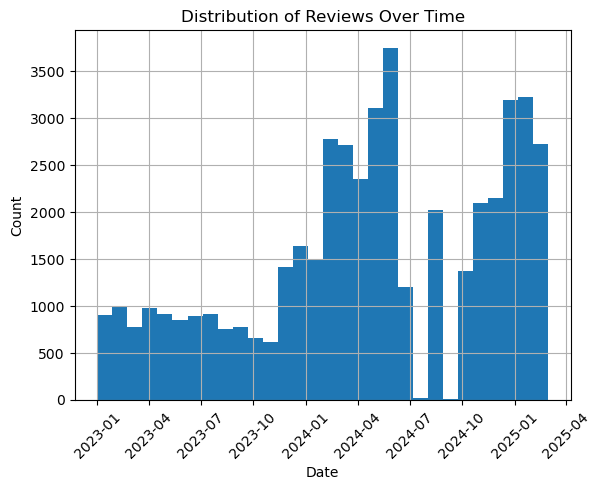

In [12]:
# looking at distribution of reviews over time

df_clean['at'].hist(bins=30) 
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Reviews Over Time')
plt.xticks(rotation=45)
plt.show()

In [13]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47309 entries, 0 to 130419
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        47309 non-null  object
 1   score          47309 non-null  int64 
 2   thumbsUpCount  47309 non-null  int64 
 3   at             47309 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.8+ MB


In [14]:
# looking at distribution of rating score column
df_clean['score'].value_counts()

score
1    22982
5    13740
2     3833
3     3391
4     3363
Name: count, dtype: int64

In [15]:
# dropping the neutral rating scores of 3

df_clean = df_clean[df_clean['score'] != 3]

# converting the rest of the rating scores to binary for negative (0) and positive (1)

df_clean['score'] = df_clean['score'].map({
    1: 0, 2:0, # negative scores
    4:1, 5:1   # positive scores
})

df_clean['score']

0         0
1         1
2         1
3         0
4         1
         ..
130404    1
130410    0
130415    0
130417    0
130419    1
Name: score, Length: 43918, dtype: int64

In [16]:
# checking the distribution of the `score` column

print(df_clean.score.value_counts(normalize=True) * 100)

score
0    61.05697
1    38.94303
Name: proportion, dtype: float64


### Feature Engineering
#### Factoring in Thumbs Up Count

The data contained in the `thumbsUpCount` column can help us determine relative significance of different user reviews: reviews with high thumbs up counts are probably more significant than reviews with 0 thumbs ups.

Since the distribution of this column's values are all over the place, we will need to scale this column to ensure proper weight is given to reviews with more thumbs up without allowing outliers to dominate our models' performances. 

Since our column is heavily skewed to the right (disproportionate number of reviews with 0 thumbs up, with a few reviews having a high number of thumbs up) we will use **log transformation** to normalize this column in a way that does not overstate extreme outliers. Specifically, we will use **log1p()** to handle the large number of 0 counts.

This will allow us to use a scaled thumbs up count as an additional Feature in our modeling.

In [17]:
# looking at distribution of ThumbsUp column

print(df_clean["thumbsUpCount"].value_counts())
print()
print(df_clean["thumbsUpCount"].describe())


thumbsUpCount
0      33541
1       4714
2       1651
3        886
4        494
       ...  
204        1
444        1
845        1
637        1
171        1
Name: count, Length: 447, dtype: int64

count    43918.000000
mean         7.170591
std         87.109358
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4502.000000
Name: thumbsUpCount, dtype: float64


In [18]:
# creating new column with log-scaled thumbs up counts

df_clean['thumbs_up_log'] = np.log1p(df_clean['thumbsUpCount']) # using log1p() to handle the 0s appropriately

df_clean['thumbs_up_log'].value_counts()

thumbs_up_log
0.000000    33541
0.693147     4714
1.098612     1651
1.386294      886
1.609438      494
            ...  
5.323010        1
6.098074        1
6.740519        1
6.458338        1
5.147494        1
Name: count, Length: 447, dtype: int64

In [19]:
df_clean.head()

,content,score,thumbsUpCount,at,thumbs_up_log
0,"Trash, it made me change my password because I...",0,0,2025-03-01,0.0
1,I love Netflix only ❤️,1,0,2025-03-01,0.0
2,it's the best but pls bring back the society s...,1,0,2025-03-01,0.0
3,"When you fold your Galaxy Fold 6, it forces Ne...",0,0,2025-03-01,0.0
4,Good,1,0,2025-03-01,0.0
...,...,...,...,...,...
130404,I'm enjoying 😎🎧,1,0,2024-05-02,0.0
130410,Does not have kannada movies,0,0,2024-03-17,0.0
130415,"Their is no position for kannada language , do...",0,0,2024-03-17,0.0
130417,The. Best App. Ever,0,0,2024-04-01,0.0


### Train-Test Split

Now that we are done cleaning our dataset, we need to assign our X and y variable. Then, we will split our data into separate sets for training our models, validating our model paramater tuning, and performing tests to evaluate our models' capabilities.

In [20]:
# assigning X and y variables

X = df_clean[['content', 'thumbs_up_log']]

y = df_clean['score']

# splitting test and training datasets

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42
)

# splitting training and validation datasets

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size = 0.2,
    random_state = 42
)

### Creating Custom Transformers

With our training, validation and test sets ready, we will create custom transformers to preprocess our text data for it to be useable in our models. 

This custom transformer, `TextPreprocessor`, will lowercase the text, remove special characters, tokenize the text, remove stop words, and lemmatize the text.  

In [21]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Preprocesses text by:
    1) Lowercasing the text
    2) Removing non-alphabetic characters
    3) Tokenizing the text
    4) Removing stopwords
    5) Lemmatizing the tokens
    """

    def __init__(self):
        self._lemmatizer = WordNetLemmatizer()
        self._stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        preprocessed_text = []

        for text in X:
            if not isinstance(text, str):  # ensure input is a string
                text = str(text)
            text = text.lower()  # lowercase
            text = re.sub(r'[^a-z\s]', '', text)  # remove special characters
            tokens = nltk.word_tokenize(text)  # tokenize
            filtered_tokens = [word for word in tokens if word not in self._stop_words]  # remove stopwords
            lemmatized_tokens = [self._lemmatizer.lemmatize(word) for word in filtered_tokens]  # lemmatize
            preprocessed_text.append(' '.join(lemmatized_tokens))  # join tokens back into a string
        
        return preprocessed_text


### Pipelines

We will prepare Pipelines to ensure systematic preprocessing and prevent data leakage.

These Pipelines will include two main steps:
1. `ColumnTransformer` that will run our TextPreprocessor on our text, vectorize that text for TF-IDF, and combine these vectors with our `thumbs_up_log` column to be run in the model.
2. `Classifier` which will run our models.

In [76]:
# creating a pipeline for Column Transformer

column_transformer = ColumnTransformer([
    ('text_features', Pipeline([
        ('preprocessor', TextPreprocessor()),  
        ('vectorizer', TfidfVectorizer()),
        ('variance_threshold', VarianceThreshold(threshold=0))  # remove constant features that don't add anything
    ]), 'content'),  
    
    ('thumbs_up', 'passthrough', ['thumbs_up_log'])  
])

In [77]:
# creating baseline Multinomial Naive Bayes pipeline with `feature_pipeline` as first step

mnb_baseline = MultinomialNB(
    class_prior=[0.39, 0.61] # countering class imbalance
)

baseline_pipeline = Pipeline([
    ('transformer', column_transformer),
    ('classifier', mnb_baseline)
])

In [78]:
# creating vanilla Logistic Regression model pipeline 

logreg_vanilla = LogisticRegression(
    random_state=42,
    class_weight='balanced' # accounting for class imbalance
)

logreg_pipeline = Pipeline([
    ('transformer', column_transformer),
    ('classifier', logreg_vanilla)
])

In [79]:
# creating LightGBM model pipeline

lgbm_vanilla = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    scale_pos_weight=61/39, # accounting for class imbalance
    verbose=-1 # suppressing logs
)

lgbm_pipeline = Pipeline([
    ('transformer', column_transformer),
    ('classifier', lgbm_vanilla)
])

### Clustering

# Modeling

In [80]:
# creating function to store model results
model_results = []

def store_results(model_name, f1):
    """
    Store metrics for all our models
    """

    model_results.append({
        'Model': model_name,
        'F1': f"{f1 * 100:.2f}%"  # format as percentage with 2 decimal places
    })

    # convert to dataframe
    global model_results_df
    model_results_df = pd.DataFrame(model_results)

In [81]:
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('text_features',
                                                  Pipeline(steps=[('preprocessor',
                                                                   TextPreprocessor()),
                                                                  ('vectorizer',
                                                                   TfidfVectorizer()),
                                                                  ('variance_threshold',
                                                                   VarianceThreshold(threshold=0))]),
                                                  'content'),
                                                 ('thumbs_up', 'passthrough',
                                                  ['thumbs_up_log'])])),
                ('classifier', MultinomialNB(class_prior=[0.39, 0.61]))])

In [82]:
y_val_pred = baseline_pipeline.predict(X_val)

baseline_f1 = f1_score(y_val, y_val_pred)

baseline_f1

0.8336380255941499

In [83]:
store_results('BaselineMNB', baseline_f1)

In [84]:
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('text_features',
                                                  Pipeline(steps=[('preprocessor',
                                                                   TextPreprocessor()),
                                                                  ('vectorizer',
                                                                   TfidfVectorizer()),
                                                                  ('variance_threshold',
                                                                   VarianceThreshold(threshold=0))]),
                                                  'content'),
                                                 ('thumbs_up', 'passthrough',
                                                  ['thumbs_up_log'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [85]:
y_val_pred_lr = logreg_pipeline.predict(X_val)

logreg_vanilla_f1 = f1_score(y_val, y_val_pred_lr)

logreg_vanilla_f1

0.858697623798295

In [86]:
store_results('LogReg Vanilla', logreg_vanilla_f1)

In [87]:
lgbm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('text_features',
                                                  Pipeline(steps=[('preprocessor',
                                                                   TextPreprocessor()),
                                                                  ('vectorizer',
                                                                   TfidfVectorizer()),
                                                                  ('variance_threshold',
                                                                   VarianceThreshold(threshold=0))]),
                                                  'content'),
                                                 ('thumbs_up', 'passthrough',
                                                  ['thumbs_up_log'])])),
                ('classifier',
                 LGBMClassifier(metric='binary_logloss', objective='binary',
                                scale_pos_weight=1.564102564102564,
                                verbose=-1))])

In [88]:
y_val_pred_lgbm = lgbm_pipeline.predict(X_val)

lgbm_vanilla_f1 = f1_score(y_val, y_val_pred_lgbm)

lgbm_vanilla_f1

0.8437057991513437

In [89]:
store_results('LightGBM Vanilla', lgbm_vanilla_f1)

All of our vanilla models performed well, with scores between 83-86%. The vanilla LogReg was the best.

## Tuning Hyperparameters

While our results from our initial modeling are good, let's see if we can boost their performance by tuning hyperparameters. We will deploy `GridSearchCV` to find the most apt arrangement of parameters for each model.

While our focus is on tuning the parameters for each model to optimize performance, we will also be tuning parameters for the vectorizer, notably in introducing **bigrams and trigrams**, which essentially represent word pairings of two or three words as the added context can be helpful as opposed to considering each word in isolation.

*For convenience, we have saved the tuned models using `joblib` for easy loading and to save time when this notebook is run in the future.*

In [90]:
# MultinomialNB Grid Search

param_mnb = {
    'transformer__text_features__vectorizer__ngram_range': [(1,1), (1,2), (1,3)],  # unigrams, bigrams, trigrams
    'transformer__text_features__vectorizer__min_df': [1, 2, 5],  # ignore rare words appearing in few documents
    'transformer__text_features__vectorizer__max_df': [0.8, 0.9, 1.0],  # Ignore very frequent words
    'transformer__text_features__vectorizer__smooth_idf': [True, False],  # Whether to smooth IDF weights
    'classifier__alpha': [0.1, 0.5, 1.0, 2.0]  # MNB alpha values
}

#random_mnb = RandomizedSearchCV( # no need to run this anymore
    #baseline_pipeline,
    #param_mnb,
    #n_iter=20,  
    #cv=3,  
    #scoring='f1',  
#)

#random_mnb.fit(X_train, y_train)

In [91]:
# saving tuned MultinomialNB model for convenience

#joblib.dump(random_mnb.best_estimator_, 'tuned_mnb.pkl')

In [92]:
# loading tuned MultinomialNB model
tuned_mnb = joblib.load('tuned_models/tuned_mnb.pkl')

In [93]:
# fitting loaded MultinomialNB model on training data
tuned_mnb.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('text_features',
                                                  Pipeline(steps=[('preprocessor',
                                                                   TextPreprocessor()),
                                                                  ('vectorizer',
                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                2)))]),
                                                  'content'),
                                                 ('thumbs_up', 'passthrough',
                                                  ['thumbs_up_log'])])),
                ('classifier',
                 MultinomialNB(alpha=0.1, class_prior=[0.39, 0.61]))])

In [94]:
# Logistic Regression Grid Search

param_logreg = {
    'transformer__text_features__vectorizer__ngram_range': [(1,1), (1,2), (1,3)],  
    'transformer__text_features__vectorizer__min_df': [1, 2, 5],  
    'transformer__text_features__vectorizer__max_df': [0.8, 0.9, 1.0],  
    'transformer__text_features__vectorizer__smooth_idf': [True, False],  
    'classifier__C': [0.01, 0.1, 1.0, 10.0, 100.0],  # strength of regularization
    'classifier__penalty': ['l2'],  # L2 regularization 
    'classifier__solver': ['lbfgs']  # efficient solver for larger datasets
}

#random_logreg = RandomizedSearchCV(
    #logreg_pipeline,
    #param_logreg,
    #n_iter=20,  
    #cv=3,  
    #scoring='f1'  
#)

#random_logreg.fit(X_train, y_train)

In [95]:
# saving tuned LogReg model

#joblib.dump(random_logreg.best_estimator_, 'tuned_logreg.pkl')

In [96]:
# loading tuned LogReg model
tuned_logreg = joblib.load('tuned_models/tuned_logreg.pkl')

In [97]:
# fitting tuned model on training data
tuned_logreg.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('text_features',
                                                  Pipeline(steps=[('preprocessor',
                                                                   TextPreprocessor()),
                                                                  ('vectorizer',
                                                                   TfidfVectorizer(min_df=5,
                                                                                   ngram_range=(1,
                                                                                                3),
                                                                                   smooth_idf=False))]),
                                                  'content'),
                                                 ('thumbs_up', 'passthrough',
                                                  ['thumbs_up_log'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [98]:
# LightGBM Grid Search

param_lgbm = {
    'transformer__text_features__vectorizer__ngram_range': [(1,1), (1,2), (1,3)],  
    'transformer__text_features__vectorizer__min_df': [1, 2, 5],  
    'transformer__text_features__vectorizer__max_df': [0.8, 0.9, 1.0],  
    'transformer__text_features__vectorizer__smooth_idf': [True, False], 
    'classifier__num_leaves': [31, 50],  # number of leaves in one tree
    'classifier__learning_rate': [0.01, 0.05],  # learning rate
    'classifier__n_estimators': [100, 200]  # number of trees
}

#random_lgbm = RandomizedSearchCV(
    #lgbm_pipeline,
    #param_lgbm,
    #n_iter=20,  
    #cv=3,  
    #scoring='f1',
    #verbose=0 # suppressing logs for readability
#)

#random_lgbm.fit(X_train, y_train)

In [99]:
# saving tuned LGBM model

#joblib.dump(random_lgbm.best_estimator_, 'tuned_lgbm.pkl')

In [100]:
# loading tuned LGBM model
tuned_lgbm = joblib.load('tuned_models/tuned_lgbm.pkl')

In [49]:
# fitting tuned LGBM model on training data
tuned_lgbm.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('text_features',
                                                  Pipeline(steps=[('preprocessor',
                                                                   TextPreprocessor()),
                                                                  ('vectorizer',
                                                                   TfidfVectorizer(max_df=0.9,
                                                                                   min_df=2,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   smooth_idf=False))]),
                                                  'content'),
                                                 ('thumbs_up', 'passthrough',
                                                  ['thumbs_up_log'])])),
                ('classifier',
                 LGBMClassifier(learning_rate=0.05, metric='binary_logloss',
                                n_estimators=200, num_leaves=50,
                                objective='binary',
                                scale_pos_weight=1.564102564102564,
                                verbose=-1))])

### Checking Model Performance on Validation Data

In [51]:
y_val_pred_mnb_tuned = tuned_mnb.predict(X_val)

tuned_mnb_f1 = f1_score(y_val, y_val_pred_mnb_tuned)

In [52]:
y_val_pred_logreg_tuned = tuned_logreg.predict(X_val)

tuned_logreg_f1 = f1_score(y_val, y_val_pred_logreg_tuned)

In [53]:
y_val_pred_lgbm_tuned = tuned_lgbm.predict(X_val)

tuned_lgbm_f1 = f1_score(y_val, y_val_pred_lgbm_tuned)

In [54]:
# storing the model results
store_results('MNB Tuned', tuned_mnb_f1)
store_results('LogReg Tuned', tuned_logreg_f1)
store_results('LGBM Tuned', tuned_lgbm_f1)

model_results_df

,Model,F1
0,BaselineMNB,83.36%
1,LogReg Vanilla,85.87%
2,LightGBM Vanilla,84.37%
3,MNB Tuned,84.70%
4,LogReg Tuned,86.03%
5,LGBM Tuned,84.79%


### Testing Tuned Models

In [56]:
y_test_pred_tuned_mnb = tuned_mnb.predict(X_test)
y_test_pred_tuned_logreg = tuned_logreg.predict(X_test)
y_test_pred_tuned_lgbm = tuned_lgbm.predict(X_test)

tuned_mnb_test_f1 = f1_score(y_test, y_test_pred_tuned_mnb)
tuned_logreg_test_f1 = f1_score(y_test, y_test_pred_tuned_logreg)
tuned_lgbm_test_f1 = f1_score(y_test, y_test_pred_tuned_lgbm)

print(f'Tuned MNB Test F1: {tuned_mnb_test_f1 * 100:.2f}%')
print()
print(f'Tuned LogReg Test F1: {tuned_logreg_test_f1 * 100:.2f}%')
print()
print(f'Tuned LGBM Test F1: {tuned_lgbm_test_f1 * 100:.2f}%')

Tuned MNB Test F1: 84.27%

Tuned LogReg Test F1: 85.75%

Tuned LGBM Test F1: 84.09%


In [67]:
test_results = {
    'Model': ['MNB Tuned', 'LogReg Tuned', 'LGBM Tuned'],
    'Test F1': [tuned_mnb_test_f1, 
                tuned_logreg_test_f1, 
                tuned_lgbm_test_f1]  
}

test_results_df = pd.DataFrame(test_results)
test_results_df['Test F1'] = test_results_df['Test F1'].apply(lambda x: f"{x*100:.2f}%")

# merging the old `model_results_df` with the new `test_results_df` on 'Model'
final_results_df = pd.merge(model_results_df, test_results_df, on='Model')

final_results_df

,Model,F1,Test F1
0,MNB Tuned,84.70%,84.27%
1,LogReg Tuned,86.03%,85.75%
2,LGBM Tuned,84.79%,84.09%


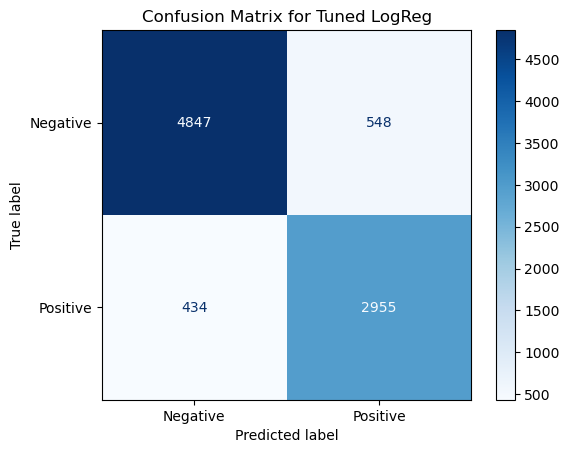

In [69]:
cm = confusion_matrix(y_test, y_test_pred_tuned_logreg)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Tuned LogReg')
plt.show()

## Feature Importances

In [71]:
# Accessing the TfidfVectorizer from the pipeline
vectorizer = logreg_pipeline.named_steps['transformer'].named_transformers_['text_features'].named_steps['vectorizer']

# Getting the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Getting the coefficients from the fitted Logistic Regression model
coefficients = logreg_pipeline.named_steps['classifier'].coef_.flatten()

# Check lengths for consistency
print(f"Number of features: {len(feature_names)}")
print(f"Number of coefficients: {len(coefficients)}")

# Ensure the lengths match
if len(feature_names) == len(coefficients):
    # Combine feature names and coefficients into a DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Sorting features by absolute coefficient values
    feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
    feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

    # Plotting the top 20 most important features
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Abs_Coefficient'][:20])
    plt.xlabel('Coefficient Magnitude')
    plt.ylabel('Feature')
    plt.title('Top 20 Feature Importances for Tuned Logistic Regression')
    plt.show()
else:
    print("The number of features and coefficients do not match. Please check your pipeline steps.")


Number of features: 18456
Number of coefficients: 18457
The number of features and coefficients do not match. Please check your pipeline steps.


In [73]:
# Checking for constant features
vectorizer = logreg_pipeline.named_steps['transformer'].named_transformers_['text_features'].named_steps['vectorizer']
X_transformed = vectorizer.transform(X_train)  # Use the appropriate training data

# Identify constant features
constant_columns = np.where(np.sum(X_transformed != 0, axis=0) == 0)[0]
print(f"Constant features found at indices: {constant_columns}")

Constant features found at indices: [0 0 0 ... 0 0 0]


In [70]:
# Accessing the TfidfVectorizer from the pipeline
vectorizer = logreg_pipeline.named_steps['transformer'].named_transformers_['text_features'].named_steps['vectorizer']

# Getting the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Getting the coefficients of the fitted Logistic Regression model
coefficients = logreg_pipeline.named_steps['classifier'].coef_.flatten()

# Combine feature names and coefficients
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort features by coefficient magnitude
feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

ValueError: All arrays must be of the same length

In [ ]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Abs_Coefficient'][:20])
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances for Tuned Logistic Regression')
plt.show()

# Conclusion

## Evaluation

## Limitations

Did not factor in neutral reviews

## Recommendations

## Next Steps